In [1]:
from IPython.display import display, HTML
display(HTML("""<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{fontsize:12pt;padding:5px;}
table.dataframe{font-size:12px;}))
</style>
"""))

<font size="5" color="red">ch09 wine품질등급예측(다중분류)</font>

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist  # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical  # 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from matplotlib import pyplot as plt  # 학습과정 loss와 acc 시각화
from sklearn.metrics import confusion_matrix  # 혼동행렬
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split  # 데이터 분리
import os
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.models import load_model, save_model
# quiz에서는 scale조정, train_test_split 등을 추가

- Red Wine 등급 예측

1. 데이터 셋 확보 및 전처리 csv → 결측치 처리 → 독립변수와 타겟변수 분리 → 독립변수 스케일조정 → 타겟변수의 원핫인코딩 → 훈련셋과 테스트셋분리(train_test_split이용 층화추출)
2. 모델 구성 (입력11, 출력6-get_dummies | 출력9-to_categorical) layer층 4
3. 모델 학습 과정 설정
4. 모델학습 (callbacks이용)
5. 모델 평가 (그래프, 평가, 교차표)
6. 모델저장 & 사용

# 1. 데이터 확보 & 전처리

In [3]:
# 데이터 읽어오기
# fixed acidity : 고정 산도
# volatile acidity : 휘발성 산도
# citric acid : 시트르산
# residual sugar : 잔류 당분
# chlorides : 염화물
# free sulfur dioxide : 자유 이산화황
# total sulfur dioxide : 총 이산화황
# density : 밀도
# pH
# sulphates : 황산염
# alcohol
# quality : 0 ~ 10(높을 수록 좋은 품질)

redwine = pd.read_csv('data/winequality-red.csv', sep = ';')
redwine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [4]:
# 결측치 확인

redwine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [12]:
# 독립변수와 타겟변수 분리

X = redwine.iloc[:, :-1].to_numpy()  # .values와 유사
y = redwine.iloc[:, -1]
X.shape, y.shape

((1599, 11), (1599,))

In [13]:
# 독립변수 scale 조정

scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.fit_transform(X)
scaled_X[:2]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711]])

In [14]:
# 타겟변수 원핫인코딩 후 numpy 배열로 변환

# Y = to_categorical(y)  # 0 0 0 0 0 0 0 0 1
Y = pd.get_dummies(y).values  # to_numpy()와 유사 0 0 0 0 0 1
Y

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]], dtype=uint8)

In [17]:
# 훈련셋과 테스트셋 분리 (7:3)

X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,
                                                   Y,
                                                   test_size = 0.3,  # 테스트셋비율
                                                   random_state = 7,
                                                   stratify = Y  # 층화추출
                                                   )
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1119, 11), (480, 11), (1119, 6), (480, 6))

In [18]:
# 층화추출을 하면 등급별 7:3으로  shuffle 되서 추출

print('train, test, all')
print(
np.c_[pd.Series(Y_train.argmax(axis = 1)).value_counts(),
      pd.Series(Y_test.argmax(axis = 1)).value_counts(),
     y.value_counts()]
)

train, test, all
[[477 204 681]
 [446 192 638]
 [139  60 199]
 [ 37  16  53]
 [ 13   5  18]
 [  7   3  10]]


# 2. 모델 구성 (입력11, 출력9) layer층 4

In [19]:
# 모델 구성하기

model = Sequential()
model.add(Input(shape = (11,)))  # 의미있는 레이어가 아니고 input_dim만 지정
model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(units = 64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(units = 30, activation = "relu"))
model.add(Dense(units = 6, activation = "softmax")) # 3 4 5 6 7 8 등급의 결과 합이 1
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1950      
                                                                 
 dense_3 (Dense)             (None, 6)                 186       
                                                                 
Total params: 11,928
Trainable params: 11,928
Non-traina

# 3. 모델 학습 과정 설정

In [20]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

# 4. 모델학습 (callbacks 이용)

In [21]:
%%time

# 매번 로그 출력하면 지저분해 질 수 있으니, 특정 에포크마다 로그 출력하도록 제한
class CustomHistory(Callback) :  # on_epoch_end()는 각 에포크 종료시 자동 호출
    def __init__(self) :  # 생성자함수
        self.epoch = 0
        
    def on_epoch_end(self, batch, logs = {}) :  # 1 epoch마다 자동 실행되는 함수
        self.epoch += 1  # epoch마다 self.epoch값을 1씩 증가
        if self.epoch % 5 == 0 :
            print('epoch : {}, loss : {}, acc : {}, val_loss : {}, val_acc : {}'.\
                  format(self.epoch, 
                        logs.get('loss'),
                        logs.get('accuracy', '-'),
                        logs.get('val_loss', '-'),
                        logs.get('val_accuracy', '-')
                  )
            )
            
model_save_folder = './model/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'wine-{epoch:03d}-val{val_accuracy:.4f}.h5'

# 모델 자동저장 콜백
checkpoint = ModelCheckpoint(filepath = file,  # 저장경로
                             monitor = 'val_accuracy',  # 모니터링할 지표 'loss', 'accuracy', 'val_loss' 등
                             save_best_only = True,  # 모니터링 지표가 개선된 경우만 저장. False로 하면 매번 에포크마다 저장
                             mode = 'max',  # 값이 클수록 좋을 때, 'min'은 값이 작을수록 좋을 때. auto도 있음
                             verbose = 1)  # 저장 시 로그 출력 (1 : 저장시 메세지 출력, 0 : 출력 안 함)

customHistory = CustomHistory()
earlyStropping = EarlyStopping(patience = 20)
hist = model.fit(X_train, Y_train, epochs = 200, batch_size = 200, 
                 validation_split = 0.2, 
                 callbacks = [earlyStropping, 
                              customHistory,
                              checkpoint],
                 verbose = 0)


Epoch 1: val_accuracy improved from -inf to 0.44196, saving model to ./model\wine-001-val0.4420.h5

Epoch 2: val_accuracy improved from 0.44196 to 0.50000, saving model to ./model\wine-002-val0.5000.h5

Epoch 3: val_accuracy improved from 0.50000 to 0.51339, saving model to ./model\wine-003-val0.5134.h5

Epoch 4: val_accuracy did not improve from 0.51339
epoch : 5, loss : 1.2223773002624512, acc : 0.5162011384963989, val_loss : 1.1383098363876343, val_acc : 0.5580357313156128

Epoch 5: val_accuracy improved from 0.51339 to 0.55804, saving model to ./model\wine-005-val0.5580.h5

Epoch 6: val_accuracy improved from 0.55804 to 0.57143, saving model to ./model\wine-006-val0.5714.h5

Epoch 7: val_accuracy improved from 0.57143 to 0.58036, saving model to ./model\wine-007-val0.5804.h5

Epoch 8: val_accuracy improved from 0.58036 to 0.61161, saving model to ./model\wine-008-val0.6116.h5

Epoch 9: val_accuracy improved from 0.61161 to 0.61607, saving model to ./model\wine-009-val0.6161.h5
epo

# 5. 모델 평가 - 그래프, 평가(테스트셋), 교차표(crosstab)

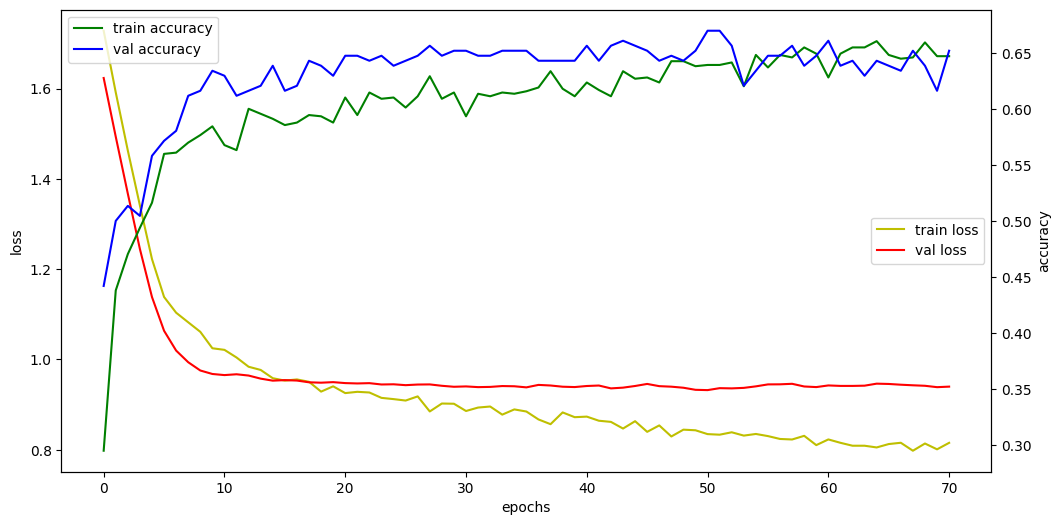

In [22]:
# 그래프 그리기

fig, loss_ax = plt.subplots(figsize = (12, 6))
loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label = 'train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label = 'val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc = 'center right')
acc_ax.legend()
plt.show()

In [23]:
# 어떤 모델을 쓸지?

loss_and_acc = model.evaluate(X_test, Y_test, batch_size = 32, verbose = 0)
print('현 모델의 loss :', loss_and_acc[0])
print('현 모델의 accuracy :', loss_and_acc[1])
model2 = load_model('model/wine-044-val0.6607.h5')
loss_and_acc2 = model2.evaluate(X_test, Y_test, batch_size = 32, verbose = 0)
print('저장된 모델 중 best모델 loss :', loss_and_acc2[0])
print('저장된 모델 중 best모델 accuracy :', loss_and_acc2[1])

현 모델의 loss : 1.0073974132537842
현 모델의 accuracy : 0.6166666746139526
저장된 모델 중 best모델 loss : 1.0189799070358276
저장된 모델 중 best모델 accuracy : 0.606249988079071


In [24]:
# 성능 지표(crosstab)
# Y_test : 0 0 1 0 0 0 (3등급, 4등급, 5등급, 6등급, 7등급, 8등급)

y = np.argmax(Y_test, axis = 1) + 3  # Y_test의 실제값(pd.getdummies)
yhat = model.predict(X_test).argmax(axis = 1) + 3  # 예측값
pd.crosstab(y, yhat, rownames = ['real'], colnames = ['predict'])

15/15 [==============================] - 0s 1ms/step


predict,4,5,6,7
real,,,,
3,1,2,0,0
4,0,10,5,1
5,1,148,53,2
6,0,54,120,18
7,0,6,26,28
8,0,0,3,2


# 6. 모델 사용하기

In [25]:
# 모델 사용하기
input_data = np.array([7.4, 0.7, 0, 1.9, 0.076, 11, 34, 0.9978, 3.51, 0.56, 9.4])
scaled_data = scaler.transform(input_data.reshape(1, 11))
print(np.argmax(model.predict(scaled_data), axis = 1) + 3, '등급으로 예측함')

1/1 [==============================] - 0s 63ms/step
[5] 등급으로 예측함
